In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import os
from scipy.interpolate import UnivariateSpline

overleaf_path = '/Users/daniel/Dropbox (Sydney Uni)/Apps/Overleaf/adra/figs/'

def mnras_size(fig_width_pt, square=False):
    inches_per_pt = 1.0/72.00              # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0     # Most aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt # Figure width in inches
    if square:
        fig_height = fig_width
    else:
        fig_height = fig_width*golden_mean
    return [fig_width,fig_height]

plt.style.use('science')

In [2]:
mnras_size(240.)

[3.333333333333333, 2.060113295832983]

In [3]:
tpfs = lk.search_targetpixelfile('alpha Draconis', mission='TESS').download_all()

In [4]:
lc_files = lk.search_lightcurvefile('alpha Draconis', mission='TESS').download_all()#.SAP_FLUX

/Users/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  """Entry point for launching an IPython kernel.


In [5]:
def fit_continuum(x, y, ivars, order=6, nsigma=[0.3,3.0], maxniter=50):
    """Fit the continuum using sigma clipping
    Args:
        x: The wavelengths
        y: The log-fluxes
        order: The polynomial order to use
        nsigma: The sigma clipping threshold: tuple (low, high)
        maxniter: The maximum number of iterations to do
    Returns:
        The value of the continuum at the wavelengths in x
    """
    A = np.vander(x - np.nanmean(x), order+1)
    m = np.ones(len(x), dtype=bool)
    for i in range(maxniter):
        m[ivars == 0] = 0  # mask out the bad pixels
        w = np.linalg.solve(np.dot(A[m].T, A[m]), np.dot(A[m].T, y[m]))
        mu = np.dot(A, w)
        resid = y - mu
        sigma = np.sqrt(np.nanmedian(resid**2))
        #m_new = np.abs(resid) < nsigma*sigma
        m_new = (resid > -nsigma[0]*sigma) & (resid < nsigma[1]*sigma)
        if m.sum() == m_new.sum():
            m = m_new
            break
        m = m_new
    return mu

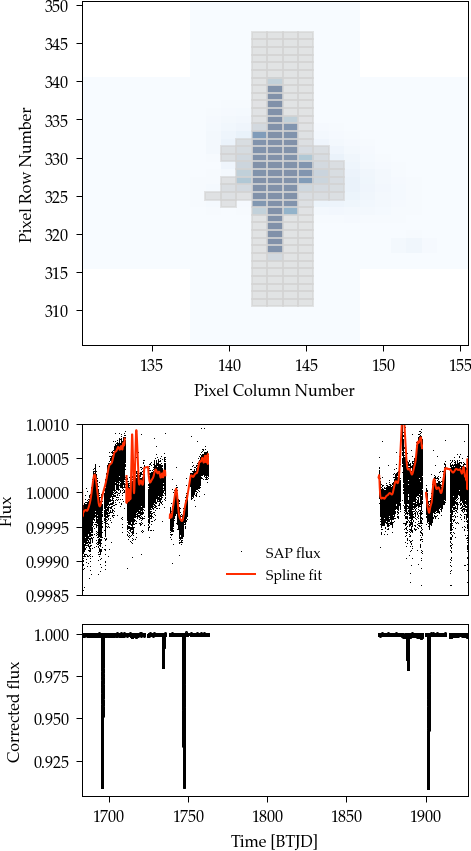

In [6]:
fig, axes = plt.subplots(3,1, figsize=[3.36,6], gridspec_kw={'height_ratios':[1,0.5,0.5]}, constrained_layout=True)

ax = axes[0]
tpfs[0].plot(ax=ax, aperture_mask=tpfs[0].pipeline_mask, style='science', aspect='auto', mask_color='lightgrey', cmap='Blues', show_colorbar=False)
ax.set(title='')

ax = axes[1]
times, fluxes, flux_errs = [], [], []
for lc in lc_files:
    lc = lc.remove_nans()
    time, flux, flux_err = lc.time.value, lc.sap_flux.value, lc.normalize().flux_err.value
    flux /= np.median(flux)
    t0_guess = time[np.argmin(flux)]
    spacing = 0.4
    mask = (time > t0_guess-spacing) & (time < t0_guess+spacing)
    
#     spl = UnivariateSpline(time[~mask], flux[~mask], k=5, s=0.1)
#     xs = np.linspace(time[0], time[-1], 1000)

    ax.plot(time[~mask], flux[~mask], ',k', rasterized=True)
    
    t = fit_continuum(time, flux, np.ones_like(time), maxniter=100, order=50)

    ax.plot(time, t, c='C3', rasterized=True)
    times.extend(time)
    fluxes.extend(flux / t)
    flux_errs.extend(flux_err)

ax.plot(time[~mask], flux[~mask], ',k', label='SAP flux', rasterized=True)
ax.plot(time, t, c='C3', label='Spline fit', rasterized=True)
ax.legend(fontsize=7)

ax.set(xlim=[lc_files[0].time.value[0], lc_files[-1].time.value[-1]],
      ylim=[0.9985, 1.001],
      xticks=[],
      ylabel='Flux')

ax = axes[2]
ax.plot(times, fluxes, '.k', markersize=1, rasterized=True)
ax.set(xlim=[times[0], times[-1]],
      ylabel='Corrected flux',
      xlabel='Time [BTJD]')

# plt.subplots_adjust(hspace=0.1)

plt.savefig(overleaf_path+'lc_corr.pdf', dpi=300, bbox_inches='tight')

In [15]:
np.savetxt('data/photometry/tess_corrected.txt', list(zip(times, fluxes, flux_errs)))